In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/week6')

In [4]:
!ls "/content/drive/My Drive/Colab Notebooks/week6"

idlmam.py		     Week06_CNN_II_IncorrectVersion.ipynb
Week06_CNN_II_Correct.ipynb  Week06_CNN_II.ipynb


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import *
from idlmam import *
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.datasets import make_moons

/content/drive/My Drive/Colab Notebooks/week6/idlmam.py:227: SyntaxWarning: invalid escape sequence '\e'
  lr_schedule -- the learning rate schedule used to alter \eta as the model trains. If this is not None than the user must also provide the optimizer to use.
/content/drive/My Drive/Colab Notebooks/week6/idlmam.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [7]:
import torchvision
from torchvision import transforms

In [8]:
mnist_data_train = torchvision.datasets.MNIST("./data", train=True,\
                                              download=True)
mnist_data_test = torchvision.datasets.MNIST("./data", train=False,\
download=True)

x_example, y_example = mnist_data_train[0]

type(x_example)


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 484kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.49MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.61MB/s]


PIL.Image.Image

In [9]:
mnist_data_train = torchvision.datasets.MNIST("./data", train=True,\
                                        download=True, \
                                        transform=transforms.ToTensor())

mnist_data_test = torchvision.datasets.MNIST("./data", train=False,\
                                   download=True, \
                                   transform=transforms.ToTensor())

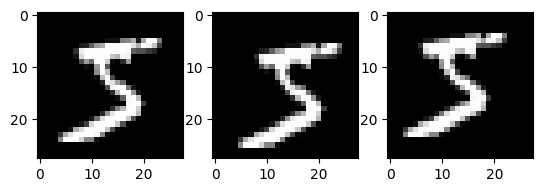

In [10]:
img_indx = 0
img, correct_class = mnist_data_train[img_indx]
img = img[0,:]
img_lr = np.roll(np.roll(img, 1, axis=1), 1, axis=0) #Moves to the lower right
img_ul = np.roll(np.roll(img, -1, axis=1), -1, axis=0) #then upper left

f, axarr = plt.subplots(1,3) #Plots the images
axarr[0].imshow(img, cmap='gray')
axarr[1].imshow(img_lr, cmap='gray')
axarr[2].imshow(img_ul, cmap='gray')
plt.show()


In [11]:
import torch.nn as nn
import torch.nn.functional as F
#We use the number of values in the input
#to help determine the size of subsequent layers:
#28 * 28 images.
D = 28*28

#No of channels in input
C = 1

classes = 10

filters = 16

#Size of Kernel
K = 3

#For comparison, let’s define a linear model
#of similar complexity.

#Simple convolutional network.
#Conv2d follows the pattern
#Conv2d(No of input channels,
#filtersoutput-channels, filter-size).

model_cnn = nn.Sequential(
  nn.Conv2d(C, filters, K, padding=K//2), # x convolve with G
  #Activation functions
  #work on any size tensor.
  nn.Tanh(),
  #Converts from (B, C, W, H) ->(B, D)
  #so we can use a Linear layer.
  nn.Flatten(),
  nn.Linear(filters*D, classes),
)


In [12]:
def train_simple_network(model, loss_func, train_loader, test_loader=None, score_funcs=None,
                         epochs=50, device="cpu", checkpoint_file=None, lr=0.001, checkpoint_every_x=None):
    """Train simple neural networks

    Keyword arguments:
    model -- the PyTorch model / "Module" to train
    loss_func -- the loss function that takes in batch in two arguments, the model outputs and the labels, and returns a score
    train_loader -- PyTorch DataLoader object that returns tuples of (input, label) pairs.
    test_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
    score_funcs -- A dictionary of scoring functions to use to evalue the performance of the model
    epochs -- the number of training epochs to perform
    device -- the compute lodation to perform training

    """
    to_track = ["epoch", "total time", "train loss"]
    if test_loader is not None:
        to_track.append("test loss")
    for eval_score in score_funcs:
        to_track.append("train " + eval_score )
        if test_loader is not None:
            to_track.append("test " + eval_score )

    total_train_time = 0 #How long have we spent in the training loop?
    results = {}
    #Initialize every item with an empty list
    for item in to_track:
        results[item] = []

    #SGD is Stochastic Gradient Decent.
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch"):
        model = model.train()#Put our model in training mode

        total_train_time += run_epoch(model, optimizer, train_loader, loss_func, device, results, score_funcs, prefix="train", desc="Training")

        results["total time"].append( total_train_time )
        results["epoch"].append( epoch )

        if test_loader is not None:
            model = model.eval()
            with torch.no_grad():
                run_epoch(model, optimizer, test_loader, loss_func, device, results, score_funcs, prefix="test", desc="Testing")

    if checkpoint_file is not None:
      if epoch % checkpoint_every_x == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'results' : results
            }, checkpoint_file)

    return pd.DataFrame.from_dict(results)

In [13]:
from torch.utils.data import *
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

B = 32
mnist_train_loader = DataLoader(mnist_data_train, batch_size=B, shuffle=True)
mnist_test_loader = DataLoader(mnist_data_test, batch_size=B)


In [14]:
loss_func = nn.CrossEntropyLoss()

cnn_results = train_simple_network(model_cnn, loss_func,\
                      mnist_train_loader, test_loader=mnist_test_loader,\
                        score_funcs={'Accuracy': accuracy_score}, \
                        device=device, epochs=20)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

In [15]:
#eval mode since not training
model = model_cnn.cpu().eval()

def pred(model, img):
    with torch.no_grad():#Always turn off gradients when evaluating

        w, h = img.shape #Finds the width/height of the image
        if not isinstance(img, torch.Tensor):
            img = torch.tensor(img) #To make sure it works for both NumPy and PyTorch Tensor

        x = img.reshape(1,-1,w,h)#reshape it as (B, C, W, H)
        logits = model(x) #Get the logits
        y_hat = F.softmax(logits, dim=1)#Turn into probabilities

    return y_hat.numpy().flatten()#convert prediction to numpy array.


In [16]:
img_pred = pred(model, img)
img_lr_pred = pred(model, img_lr)
img_ul_pred = pred(model, img_ul)

print("Org Img Class {} Prob:         ".format(correct_class) , \
      img_pred[correct_class])
print("Lower Right Img Class {} Prob: ".format(correct_class) , \
      img_lr_pred[correct_class])
print("Upper Left Img Class {} Prob:   ".format(correct_class) , \
      img_ul_pred[correct_class])


Org Img Class 5 Prob:          0.76809335
Lower Right Img Class 5 Prob:  0.43744415
Upper Left Img Class 5 Prob:    0.3704054


In [17]:
model_cnn_pool = nn.Sequential(
  nn.Conv2d(C, filters, 3, padding=3//2),
  nn.Tanh(),
  nn.Conv2d(filters, filters, 3, padding=3//2),
  nn.Tanh(),
  nn.Conv2d(filters, filters, 3, padding=3//2),
  nn.Tanh(),
  nn.MaxPool2d(2),
  nn.Conv2d(filters, 2*filters, 3, padding=3//2),
  nn.Tanh(),
  nn.Conv2d(2*filters, 2*filters, 3, padding=3//2),
  nn.Tanh(),
  nn.Conv2d(2*filters, 2*filters, 3, padding=3//2),
  nn.Tanh(),
  nn.MaxPool2d(2),

  nn.Flatten(),
  #Why did we reduce the number of units into the Linear layer by a
  #factor of 4 to power 2? Because pooling a 2x2 grid down to one value
  #means we go from 4 values, down to 1, and we did this two times.
  nn.Linear(2*filters*D//(4**2), classes),
)

loss_func = nn.CrossEntropyLoss()

cnn_results_with_pool = train_simple_network(model_cnn_pool, \
                            loss_func, \
                            mnist_train_loader, \
                            test_loader=mnist_test_loader, \
                            score_funcs={'Accuracy': accuracy_score}, \
                            device=device, epochs=20)


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

In [18]:
model = model_cnn_pool.cpu().eval()
img_pred = pred(model, img)
img_lr_pred = pred(model, img_lr)
img_ul_pred = pred(model, img_ul)

print("Org Img Class {} Prob:         ".format(correct_class) , img_pred[correct_class])
print("Lower Right Img Class {} Prob: ".format(correct_class) , img_lr_pred[correct_class])
print("Uper Left Img Class {} Prob:   ".format(correct_class) , img_ul_pred[correct_class])


Org Img Class 5 Prob:          0.7847496
Lower Right Img Class 5 Prob:  0.7192379
Uper Left Img Class 5 Prob:    0.8383986


<Axes: xlabel='epoch', ylabel='test Accuracy'>

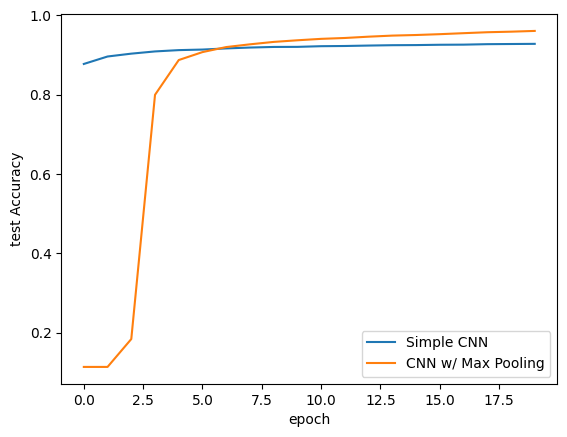

In [19]:
sns.lineplot(x='epoch', y='test Accuracy', data=cnn_results, label='Simple CNN')
sns.lineplot(x='epoch', y='test Accuracy', data=cnn_results_with_pool, label='CNN w/ Max Pooling')


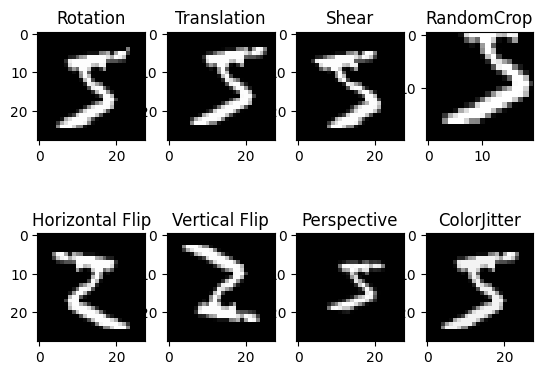

In [20]:
#Built-in transformations, given some large values to make impact more obvious.
sample_transforms = {
    "Rotation" : transforms.RandomAffine(degrees=45),
    "Translation" : transforms.RandomAffine(degrees=0, translate=(0.1,0.1)),
    "Shear": transforms.RandomAffine(degrees=0, shear=45),
    "RandomCrop" : transforms.RandomCrop((20,20)),
    "Horizontal Flip" : transforms.RandomHorizontalFlip(p=1.0),
    "Vertical Flip": transforms.RandomVerticalFlip(p=1.0),
    "Perspective": transforms.RandomPerspective(p=1.0),
    "ColorJitter" : transforms.ColorJitter(brightness=0.9, contrast=0.9)
}
#Convert the Tensor image back to a PIL image using a transform
pil_img = transforms.ToPILImage()(img)

#Plot a random application of each transform
f, axarr = plt.subplots(2,4)
for count, (name, t) in enumerate(sample_transforms.items()):
    row = count % 4
    col = count // 4
    axarr[col,row].imshow(t(pil_img), cmap='gray')
    axarr[col,row].set_title(name)
plt.show()


In [21]:
train_transform = transforms.Compose([
    transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.98, 1.02)),
    transforms.ToTensor(),
])

test_transform = transforms.ToTensor()

mnist_train_t = torchvision.datasets.MNIST("./data", train=True, \
                                           transform=train_transform)
mnist_test_t = torchvision.datasets.MNIST("./data", train=False, \
                                          transform=test_transform)
mnist_train_loader_t = DataLoader(mnist_train_t, shuffle=True,  \
                                  batch_size=B, num_workers=5)
mnist_test_loader_t = DataLoader(mnist_test_t, batch_size=B, num_workers=5)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [22]:
model_cnn_pool = nn.Sequential(
  nn.Conv2d(C, filters, 3, padding=3//2),
  nn.Tanh(),
  nn.Conv2d(filters, filters, 3, padding=3//2),
  nn.Tanh(),
  nn.Conv2d(filters, filters, 3, padding=3//2),
  nn.Tanh(),
  nn.MaxPool2d(2),
  nn.Conv2d(filters, 2*filters, 3, padding=3//2),
  nn.Tanh(),
  nn.Conv2d(2*filters, 2*filters, 3, padding=3//2),
  nn.Tanh(),
  nn.Conv2d(2*filters, 2*filters, 3, padding=3//2),
  nn.Tanh(),
  nn.MaxPool2d(2),
  nn.Flatten(),
  nn.Linear(2*filters*D//(4**2), classes),
)
loss_func = nn.CrossEntropyLoss()

cnn_results_with_pool_augmented = train_simple_network(model_cnn_pool,\
                                     loss_func, \
                                     mnist_train_loader_t, \
                                     test_loader=mnist_test_loader_t, \
                                     score_funcs={'Accuracy': \
                                     accuracy_score}, \
                                     device=device, epochs=20)


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Testing:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Testing:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Testing:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Testing:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Testing:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Testing:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Testing:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Testing:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Testing:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Testing:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Testing:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Testing:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Testing:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Testing:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Testing:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Testing:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Testing:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Testing:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Testing:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


<Axes: xlabel='epoch', ylabel='test Accuracy'>

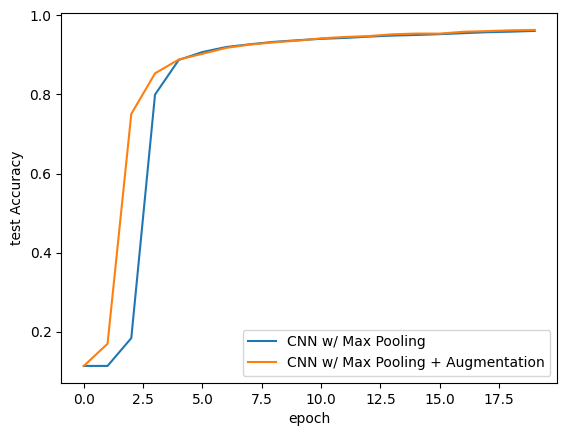

In [23]:
sns.lineplot(x='epoch', y='test Accuracy', \
             data=cnn_results_with_pool, label='CNN w/ Max Pooling')
sns.lineplot(x='epoch', y='test Accuracy', \
             data=cnn_results_with_pool_augmented, \
             label='CNN w/ Max Pooling + Augmentation')
